In [1]:
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image

class OxfordPetsSegmentation(Dataset):
    def __init__(self, root='.', split='train', image_size=128):
        self.dataset = OxfordIIITPet(root=root, download=True, target_types='segmentation')
        self.images = self.dataset._images
        self.masks = self.dataset._segs
        total = len(self.images)
        if split == 'train':
            self.images = self.images[:int(0.8 * total)]
            self.masks = self.masks[:int(0.8 * total)]
        else:
            self.images = self.images[int(0.8 * total):]
            self.masks = self.masks[int(0.8 * total):]

        self.img_transform = T.Compose([T.Resize((image_size, image_size)), T.ToTensor()])
        self.mask_transform = T.Compose([T.Resize((image_size, image_size), interpolation=Image.NEAREST), T.PILToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        img = self.img_transform(img)
        mask = self.mask_transform(mask).squeeze(0) - 1
        return img, mask.long()


In [2]:

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=3):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        # input (1, 3, 128, 128)
        e1 = self.enc1(x) # e1 - (1, 64, 128, 128)
        e2 = self.enc2(self.pool1(e1)) # e2 - (1, 128, 64, 64)
        e3 = self.enc3(self.pool2(e2)) # e3 - (1, 256, 32, 32)
        e4 = self.enc4(self.pool3(e3)) # e4 - (1, 512, 16, 16)
        b = self.bottleneck(self.pool4(e4)) # e5 - (1, 1024, 8, 8)

        d4 = self.up4(b) # d4 - (1, 512, 16, 16)
        d4 = torch.cat([d4, e4], dim=1) # d4 = d4 + e4 - (1, 1024, 16, 16)
        d4 = self.dec4(d4) # d4 - (1, 512, 16, 16)

        d3 = self.up3(d4) # d3 - (1, 256, 32, 32)
        d3 = torch.cat([d3, e3], dim=1) # d3 = d3+e3 - (1, 512, 32, 32)
        d3 = self.dec3(d3) # d3 - (1, 256, 32, 32)

        d2 = self.up2(d3) # d2 - (1, 128, 64, 64)
        d2 = torch.cat([d2, e2], dim=1) # d2 = d2 + e2 - (1, 256, 64, 64)
        d2 = self.dec2(d2) # d2 - (1, 128, 64, 64)

        d1 = self.up1(d2) # d1 - (1, 64, 128, 128)
        d1 = torch.cat([d1, e1], dim=1) # d1 = d1+e1 - (1, 128, 128, 128)
        d1 = self.dec1(d1) # d1 - (1, 64, 128, 128)

        return self.final(d1) # (1, 3, 128, 128)


In [3]:

from torch.utils.data import Dataset, DataLoader

train_data = OxfordPetsSegmentation(split='train')
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = UNet(in_channels=3, out_classes=3).cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
for epoch in range(5):
    model.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg = running_loss / len(train_loader)
    losses.append(avg)
    print(f"Epoch {epoch+1}, Loss: {avg:.4f}")

100%|██████████| 792M/792M [00:39<00:00, 20.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.2MB/s]


Epoch 1, Loss: 0.8563
Epoch 2, Loss: 0.7707
Epoch 3, Loss: 0.7423
Epoch 4, Loss: 0.7253
Epoch 5, Loss: 0.7172


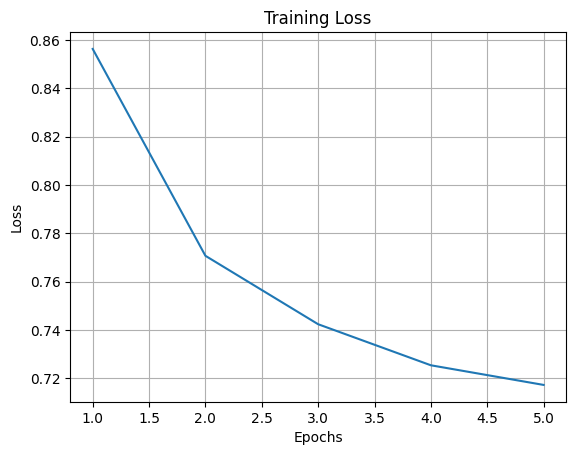

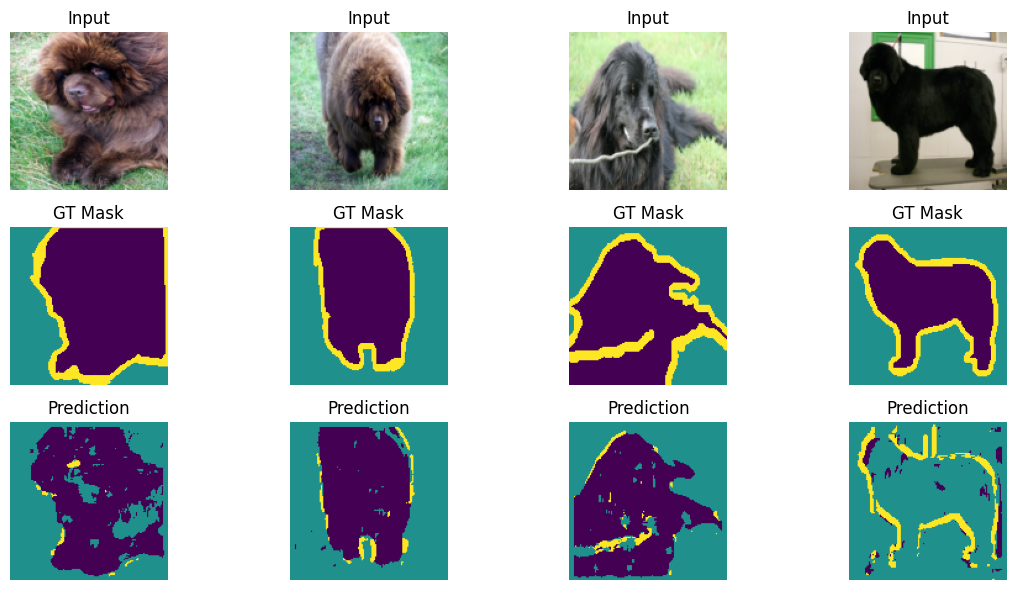

In [4]:

# Plot loss
import matplotlib.pyplot as plt
plt.plot(range(1, 6), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# Visualize predictions
test_data = OxfordPetsSegmentation(split='test')
test_loader = DataLoader(test_data, batch_size=4)
x, y = next(iter(test_loader))
x = x.cuda()
with torch.no_grad():
    model.eval()
    pred = torch.argmax(model(x), dim=1).cpu()

# Plot
fig, axes = plt.subplots(3, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(x[i].permute(1, 2, 0).cpu())
    axes[1, i].imshow(y[i])
    axes[2, i].imshow(pred[i])
    axes[0, i].set_title("Input")
    axes[1, i].set_title("GT Mask")
    axes[2, i].set_title("Prediction")
    for j in range(3): axes[j, i].axis('off')
plt.tight_layout()
plt.show()
